In [3]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [15]:
!pip install mediapipe scikit-learn matplotlib


In [16]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os


In [17]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


In [20]:
DATA_DIR = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"  
LABELS = sorted(os.listdir(DATA_DIR))  

data = []
labels = []

for label in LABELS:
    folder_path = os.path.join(DATA_DIR, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        
       
        if image is None:
            print(f"Could not load image: {image_path}")
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = hands.process(image)
        
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append(landmarks)
                labels.append(label)



In [21]:
data = np.array(data)
labels = np.array(labels)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)


In [22]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9952175992348159
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       146
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00       162
           4       0.99      0.99      0.99       167
           5       0.99      1.00      0.99       154
           6       1.00      1.00      1.00       171
           7       1.00      0.99      1.00       172
           8       1.00      1.00      1.00       184
           9       1.00      1.00      1.00       150
          10       1.00      0.99      1.00       178
          11       0.99      0.99      0.99       167
          12       0.99      1.00      1.00       160
          13       0.99      1.00      0.99       163
          14       0.99      0.99      0.99       153
          15       1.00      1.00      1.00       139
          16       1.00      1.00      1.00       14

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import joblib

joblib.dump(clf, "asl_classifier.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

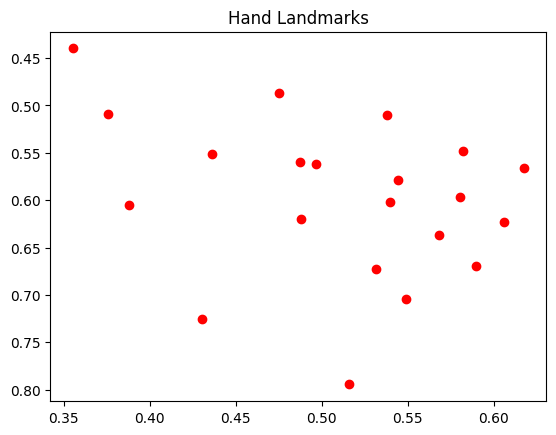

In [24]:
def plot_landmarks(landmarks):
    x = landmarks[::3]
    y = landmarks[1::3]
    plt.scatter(x, y, c="red")
    plt.title("Hand Landmarks")
    plt.gca().invert_yaxis()
    plt.show()

plot_landmarks(data[0])


In [ ]:
#single image testing 

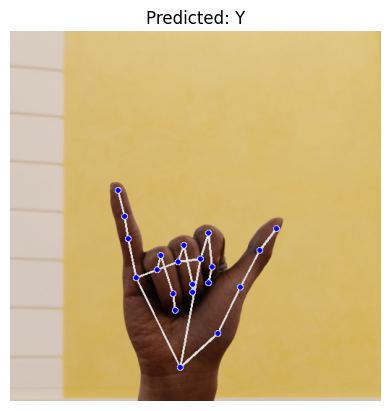

Predicted Class: Y


In [31]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from matplotlib import pyplot as plt

# Load the saved model and label encoder
clf = joblib.load("asl_classifier.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# Function to preprocess and predict
def predict_sign(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load the image.")
        return None
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect hand landmarks
    result = hands.process(image)
    
    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            
            # Convert to NumPy array and reshape
            landmarks = np.array(landmarks).reshape(1, -1)
            
            # Predict using the trained model
            pred_label = clf.predict(landmarks)
            predicted_class = label_encoder.inverse_transform(pred_label)
            
            # Draw landmarks on the image
            mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Display the image
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class[0]}")
            plt.axis("off")
            plt.show()
            
            return predicted_class[0]
    else:
        print("No hand landmarks detected.")
        return None

# Test on a single image
image_path = "/kaggle/input/synthetic-asl-alphabet/Test_Alphabet/Y/14274ddb-2c37-4143-aabe-111fd6d5f18e.rgb_0000.png"  # Replace with a valid test image path
predicted_class = predict_sign(image_path)
print(f"Predicted Class: {predicted_class}")


In [ ]:
# 2

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Define paths
data_dir = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet" 
output_file = "landmarks.csv"  


data = []
labels = []

for label in tqdm(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            continue
        
        # Convert the image to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with MediaPipe
        result = hands.process(rgb_image)
        
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Extract landmarks
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append(landmarks)
                labels.append(label)
                break  # Use only the first detected hand

# Save to CSV
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv(output_file, index=False)
print(f"Landmarks saved to {output_file}")


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load the dataset
df = pd.read_csv("landmarks.csv")
X = df.iloc[:, :-1].values  # Landmark features
y = df['label'].values      # Labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a custom dataset
class LandmarkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LandmarkDataset(X_train, y_train)
test_dataset = LandmarkDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [36]:
class LandmarkClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [38]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]  # Number of landmark features
num_classes = len(label_encoder.classes_)
model = LandmarkClassifier(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 2.3786
Epoch [2/10], Loss: 1.0295
Epoch [3/10], Loss: 0.6039
Epoch [4/10], Loss: 0.4438
Epoch [5/10], Loss: 0.3501
Epoch [6/10], Loss: 0.3077
Epoch [7/10], Loss: 0.2706
Epoch [8/10], Loss: 0.2423
Epoch [9/10], Loss: 0.2250
Epoch [10/10], Loss: 0.2035


In [1]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


NameError: name 'model' is not defined

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'
test_dir = '/kaggle/input/synthetic-asl-alphabet/Test_Alphabet'

In [16]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)
        
    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [18]:
train_df.sample(15)

,filename,label
12092,Blank/60cca40e-e0ad-4e22-8272-e7e8292aa378.rgb...,Blank
11663,Y/d5b519aa-56cc-403a-8d9b-f93f61bbf7b8.rgb_000...,Y
2900,I/470f29bf-da7a-4790-996b-600035ee5395.rgb_000...,I
23131,D/78180cac-f447-45dc-bd11-2ae59d40043a.rgb_000...,D
19134,C/f0697840-2363-44a8-98f4-482997d48863.rgb_000...,C
9577,K/fff2284b-10d1-4782-bc3a-a1e4e9176f75.rgb_000...,K
4544,H/031b8600-17c7-4d74-8d1b-a484599fed0b.rgb_000...,H
4777,H/bb5ba9d0-8668-4bc6-86ca-5f415abbac3a.rgb_000...,H
7907,M/04a68df2-e1bd-4df4-a8d1-d8a946ca769c.rgb_000...,M
477,N/d46527c5-01c2-48ec-ad9e-d995ab7facd3.rgb_000...,N


In [19]:
train_df['label'].value_counts()

label
N        900
R        900
B        900
I        900
F        900
H        900
E        900
U        900
M        900
X        900
K        900
Q        900
Y        900
Blank    900
S        900
G        900
A        900
O        900
T        900
V        900
Z        900
C        900
P        900
L        900
W        900
D        900
J        900
Name: count, dtype: int64

In [20]:
def show_img(path, row):
    filename = list(row['filename'])[0]
    label = list(row['label'])[0]
    image = cv2.imread(path + '/' + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

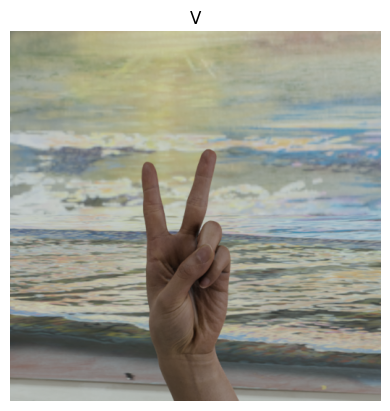

In [23]:
show_img(train_dir, train_df.sample(1))

In [24]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(19440,)
(4860,)


In [26]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [27]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 19440 validated image filenames belonging to 27 classes.
Found 4860 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames.


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Update the filename to use `.keras` extension
cb = [ModelCheckpoint('model_resnet.keras', save_best_only=True, monitor='val_loss')]


In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
n_class = 27

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='input_layer')
out = base_model(inputs, training=False)
out = GlobalAveragePooling2D()(out)
out = Dense(128, activation='relu')(out)
# out = Dropout(0.2)(out)
out = Dense(n_class, activation='softmax', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.Adamax(learning_rate=1e-4),
                     metrics=['accuracy'])

model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,830,555 (90.91 MB)

 Trainable params: 265,755 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [39]:
history_resnet = model_resnet.fit(train_generator, epochs=20,
                                  validation_data=valid_generator,
                                  batch_size=128,
                                  callbacks=cb)

Epoch 1/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.1437 - loss: 3.0371 - val_accuracy: 0.4663 - val_loss: 1.9859
Epoch 2/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 448s 730ms/step - accuracy: 0.5241 - loss: 1.7904 - val_accuracy: 0.6409 - val_loss: 1.3664
Epoch 3/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 710ms/step - accuracy: 0.6686 - loss: 1.2671 - val_accuracy: 0.7121 - val_loss: 1.0742
Epoch 4/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 711ms/step - accuracy: 0.7380 - loss: 1.0065 - val_accuracy: 0.7461 - val_loss: 0.9281
Epoch 5/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 438s 714ms/step - accuracy: 0.7690 - loss: 0.8696 - val_accuracy: 0.7840 - val_loss: 0.8164
Epoch 6/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 442s 721ms/step - accuracy: 0.7915 - loss: 0.7768 - val_accuracy: 0.7916 - val_loss: 0.7468
Epoch 7/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 711ms/step - accuracy: 0.8165 - loss: 0.6852 - val_accuracy: 0.8163 - val_loss: 0.6913
Epoch 8/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 438s 715ms/step - accuracy: 0.8348 - lo

In [40]:
history_resnet_temp = history_resnet

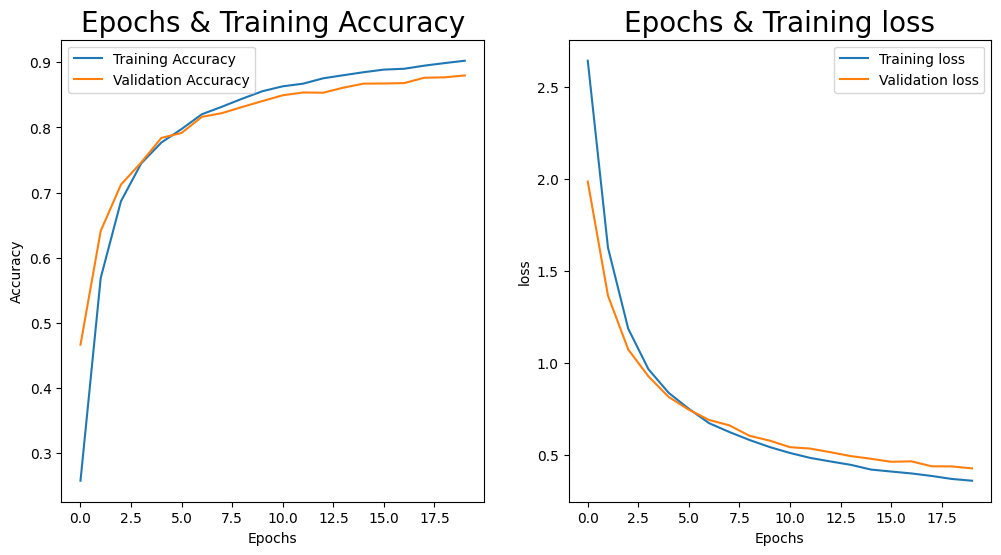

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet_temp.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet_temp.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet_temp.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet_temp.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [42]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step


In [43]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [44]:
accuracy_score(test['label'], pred_resnet)

0.8925925925925926

In [45]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.94      0.92      0.93       100
           B       0.96      0.88      0.92       100
       Blank       0.99      0.98      0.98       100
           C       0.96      0.93      0.94       100
           D       0.89      0.85      0.87       100
           E       0.83      0.85      0.84       100
           F       0.91      0.95      0.93       100
           G       0.91      0.97      0.94       100
           H       0.94      0.97      0.96       100
           I       0.84      0.92      0.88       100
           J       0.91      0.98      0.94       100
           K       0.80      0.88      0.84       100
           L       0.98      0.91      0.94       100
           M       0.78      0.64      0.70       100
           N       0.78      0.80      0.79       100
           O       0.89      0.94      0.91       100
           P       0.94      0.99      0.97       100
           Q       0.98    

In [46]:
model_resnet.save('resnet50v2_20_ep.hdf5')

In [48]:
history_resnet = model_resnet.fit(train_generator,
                                  initial_epoch=20,
                                  epochs=30,
                                  validation_data=valid_generator,
                                  batch_size=128,
                                  callbacks=cb)

Epoch 21/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 465s 758ms/step - accuracy: 0.9099 - loss: 0.3442 - val_accuracy: 0.8782 - val_loss: 0.4299
Epoch 22/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 438s 714ms/step - accuracy: 0.9080 - loss: 0.3433 - val_accuracy: 0.8846 - val_loss: 0.4143
Epoch 23/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 456s 744ms/step - accuracy: 0.9114 - loss: 0.3277 - val_accuracy: 0.8788 - val_loss: 0.4089
Epoch 24/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 454s 741ms/step - accuracy: 0.9169 - loss: 0.3158 - val_accuracy: 0.8837 - val_loss: 0.3964
Epoch 25/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 453s 739ms/step - accuracy: 0.9138 - loss: 0.3170 - val_accuracy: 0.8821 - val_loss: 0.3928
Epoch 26/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 466s 760ms/step - accuracy: 0.9176 - loss: 0.3094 - val_accuracy: 0.8881 - val_loss: 0.3867
Epoch 27/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 460s 750ms/step - accuracy: 0.9198 - loss: 0.2977 - val_accuracy: 0.8879 - val_loss: 0.3843
Epoch 28/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 460s 750ms/step - accuracy: 

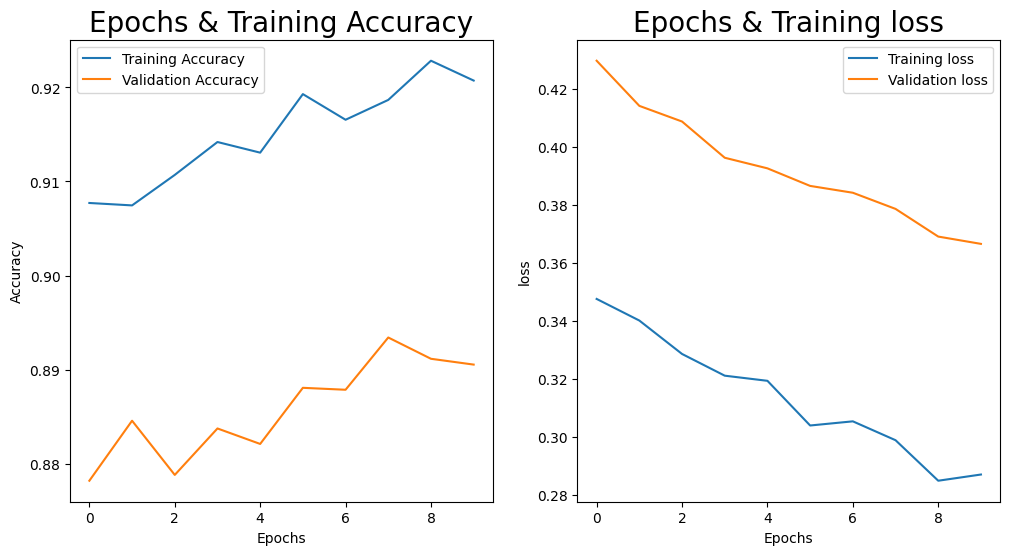

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [50]:
def concate_history(metric='accuracy', history1=history_resnet_temp, 
                    history2=history_resnet):
    history = pd.concat([pd.DataFrame(history1.history[metric]),
                        pd.DataFrame(history2.history[metric])])
    history.columns = [metric]
    history.reset_index(drop=True, inplace=True)
    
    return history

In [51]:
# Accuracy
acc_history = concate_history()

# Validation Accuracy
val_acc_history = concate_history('val_accuracy')

# Loss
loss_history = concate_history('loss')

# Validation Loss
val_loss_history = concate_history('val_loss')

In [52]:
full_history = pd.DataFrame({
    'accuracy' : acc_history['accuracy'].tolist(),
    'val_accuracy' : val_acc_history['val_accuracy'].tolist() ,
    'loss' : loss_history['loss'].tolist() ,
    'val_loss' : val_loss_history['val_loss'].tolist()
}, index=[_ for _ in range(30)])

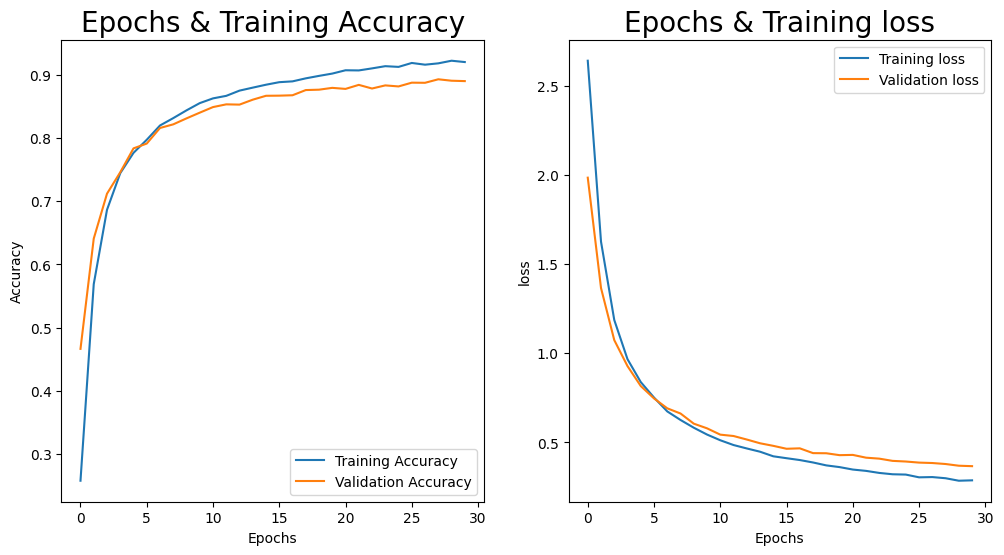

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(full_history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(full_history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(full_history['loss'], '-', label = 'Training loss')
ax[1].plot(full_history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [54]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


In [55]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [56]:
accuracy_score(test['label'], pred_resnet)

0.914074074074074

In [57]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.95      0.95      0.95       100
           B       0.96      0.89      0.92       100
       Blank       0.99      0.98      0.98       100
           C       0.97      0.93      0.95       100
           D       0.89      0.86      0.87       100
           E       0.90      0.88      0.89       100
           F       0.95      0.93      0.94       100
           G       0.94      0.97      0.96       100
           H       0.95      0.97      0.96       100
           I       0.93      0.91      0.92       100
           J       0.97      0.97      0.97       100
           K       0.85      0.90      0.87       100
           L       0.96      0.96      0.96       100
           M       0.81      0.73      0.77       100
           N       0.78      0.86      0.82       100
           O       0.89      0.96      0.92       100
           P       0.97      0.99      0.98       100
           Q       0.98    

In [59]:
model_resnet.save('finalresnet50v2_30_ep.hdf5')